In [3]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions he

2.15.1


In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/Maoriwords_violencedataset.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataframe
print(df.head())

# Strip whitespace from all column names
df.columns = df.columns.str.strip()

df.shape

      Tweet_ID                                               text  \
0  ID_0022DWKP  Had a dream i got p?wherad last night. By a gu...   
1  ID_0058QG76  My Husband patu Me Frequently, Wife Tells Cour...   
2  ID_004BBHOD  I was p?whera t?kinod for 3 years at age 4 to ...   
3  ID_004F7516  !!! RT @mayaso?taahua: As a woman you shouldn'...   
4  ID_0052TYKI  " momma said no whakap?raru cats inside my dog...   

          label_name  label  
0    sexual_violence      0  
1  physical_violence      1  
2    sexual_violence      0  
3       non_violence      2  
4       non_violence      2  


(6616, 4)

In [6]:
# Grouping data by label
df.groupby('label').count()

,Tweet_ID,text,label_name
label,,,
0,2820,2820,2820
1,2649,2649,2649
2,1147,1147,1147


In [7]:
#Splitting the data between train, validation and test sets:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.40,
    random_state=700,
    stratify=df.label.values,
)
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.40,
    random_state=200,
    stratify=df.loc[X_train_].label.values,
)
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'
df.groupby(['label_name', 'label', 'data_type']).count()

Tweet_ID  text
label_name        label data_type                
non_violence      2     test            459   459
                        train           413   413
                        val             275   275
physical_violence 1     test           1060  1060
                        train           953   953
                        val             636   636
sexual_violence   0     test           1128  1128
                        train          1015  1015
                        val             677   677

In [8]:
df

,Tweet_ID,text,label_name,label,data_type
0,ID_0022DWKP,Had a dream i got p?wherad last night. By a gu...,sexual_violence,0,train
1,ID_0058QG76,"My Husband patu Me Frequently, Wife Tells Cour...",physical_violence,1,test
2,ID_004BBHOD,I was p?whera t?kinod for 3 years at age 4 to ...,sexual_violence,0,val
3,ID_004F7516,!!! RT @mayaso?taahua: As a woman you shouldn'...,non_violence,2,val
4,ID_0052TYKI,""" momma said no whakap?raru cats inside my dog...",non_violence,2,train
...,...,...,...,...,...
6611,ID_32AX5YTC,&#8220;@JerGucci: @1__dev You the Real MVP&#82...,physical_violence,1,train
6612,ID_32CZXXLO,&#8220;@JestonaeLives: Burnt whakap?raru lips ...,physical_violence,1,test
6613,ID_32TARBR3,&#8220;@JoeBudden: The bad whakap?raru are onl...,physical_violence,1,val
6614,ID_32XR82XM,"&#8220;@JulianSantomaur: 5""0 with 30 hoes on m...",physical_violence,1,train


In [9]:
#TRAIN DATA
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,Tweet_ID,text,label_name,label,data_type
0,ID_0022DWKP,Had a dream i got p?wherad last night. By a gu...,sexual_violence,0,train
4,ID_0052TYKI,""" momma said no whakap?raru cats inside my dog...",non_violence,2,train
8,ID_00A89HJ5,"""@ArizonasFinest6: Why the eggplant emoji doe?...",non_violence,2,train
12,ID_00BXFFCR,"""@EdgarPixar: Overdosing on heavy drugs doesn'...",non_violence,2,train
16,ID_00FBBFAB,"""@HermosaAlma: This isn't ghetto.....it's smar...",non_violence,2,train


In [10]:
#VAL DATA
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,Tweet_ID,text,label_name,label,data_type
2,ID_004BBHOD,I was p?whera t?kinod for 3 years at age 4 to ...,sexual_violence,0,val
3,ID_004F7516,!!! RT @mayaso?taahua: As a woman you shouldn'...,non_violence,2,val
5,ID_005VM1DJ,"""@rorohiko2Guys: -SimplyrorohikoToGuys http://...",non_violence,2,val
6,ID_0060BW8R,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",non_violence,2,val
7,ID_007FAIEI,"""@Allyhaaaaa: Lemmie haupa a Oreo &amp; do the...",non_violence,2,val


In [11]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,Tweet_ID,text,label_name,label,data_type
1,ID_0058QG76,"My Husband patu Me Frequently, Wife Tells Cour...",physical_violence,1,test
10,ID_00AWI88Y,"""@DomWorldPeace: Baseball season for the win. ...",non_violence,2,test
11,ID_00B6KO4G,"""@DunderbaIl: I'm an early bird and I'm a nigh...",non_violence,2,test
15,ID_00F2VJM8,"""@FunnyPicsDepot: this the ""I play soccer, chh...",non_violence,2,test
19,ID_00IUWBD2,"""@KnightfanNeal #UCFPINKPARTY come on stay ali...",non_violence,2,test


In [12]:
df.dtypes

,0
Tweet_ID,object
text,object
label_name,object
label,int64
data_type,object


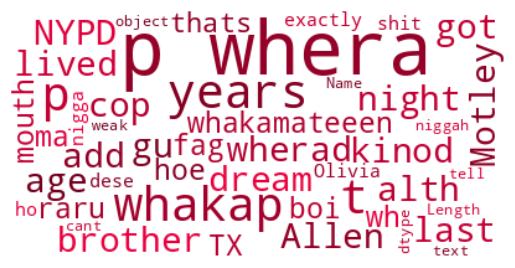

In [13]:
# WORDCLOUD FOR SEXUAL VIOLENCE - LABEL '0'
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

stopwords = set(STOPWORDS)
stopwords.add("RT")

def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "sexual_violence"]['text']))  # Updated column name

fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()


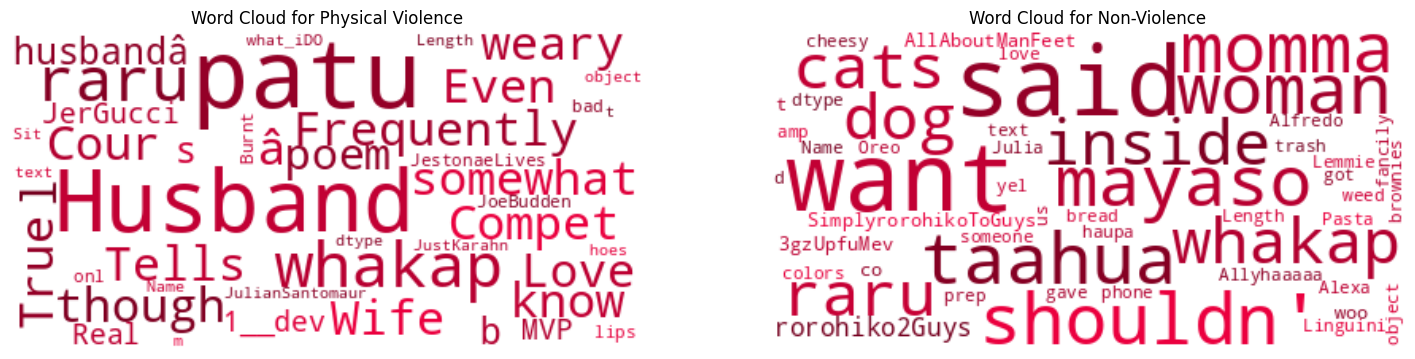

In [14]:
# Generate word cloud for physical violence
wordcloud_physical = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "physical_violence"]['text']))

# Generate word cloud for non-violence
wordcloud_non_violence = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(str(df.loc[df["label_name"] == "non_violence"]['text']))

# Plotting the word clouds
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

ax[0].imshow(wordcloud_physical.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
ax[0].set_title('Word Cloud for Physical Violence')
ax[0].axis('off')

ax[1].imshow(wordcloud_non_violence.recolor(color_func=random_color_func, random_state=3), interpolation="bilinear")
ax[1].set_title('Word Cloud for Non-Violence')
ax[1].axis('off')

plt.show()

Build TensorFlow input

In [15]:
# Ensure the text column is converted to string
df_train['text'] = df_train['text'].astype(str)
df_val['text'] = df_val['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

<ipython-input-15-c44e92f4a725>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].astype(str)
<ipython-input-15-c44e92f4a725>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['text'] = df_val['text'].astype(str)
<ipython-input-15-c44e92f4a725>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))


In [17]:
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b"@patrickstpierre You're a p?wheraing faggot."
 b'@maggie_burdis @nickgoldapp lmao dude you are probably the biggest fag in nebraska &#128514;&#128514;&#128514;&#128514;&#128514;'
 b"Woman Begs Court To Dissolve Marriage, Says 'My husband p?wheras, patu Me Always':  "
 b"@jakiekoelewijn nigga who's bitch u p?wheraing cracker get your gay ass out my mentions."
 b'The times they tried to p?whera me was ridiculous. Including one where a paid officer training from UAE roofied me n another officer cadet n tried to p?whera me first, I was barely conscious on my room floor n he could not fit his penis in me , so he p?wherad my friend'
 b'Walter Estrada just said that he held me down and p?wherad me and may have taken a little token from my place for himself and I may not like what he took. Get a search warrant for all his properties and places where he works. Look undernhaupah furniture.'
 b'Can #faggots of #HoneyBooBoo imagine this #internet world was crhaupaed to trap them and f

Loading models from TensorFlow Hub

In [22]:
#bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


Preprocessing model

In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [24]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'"when guys say "Latinas &gt;" they mean the Kim Kardashian looking girls not you whakap?raru that shaped like a mini fridge &amp; smell like tortillas"'
Label : 1
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1000  2043  4364  2360  1000  3763  3022  1004 14181  1025  1000]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [26]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.65411025 -0.38579515 -0.7972263   0.45391816  0.5886121  -0.16235802
  0.30030066  0.2927382  -0.47688383 -0.9996249  -0.26879707  0.7051436 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.11015542 -0.2573622  -0.04023466 ... -0.5244182   0.49485612
   0.27805042]
 [ 0.37800443 -0.22944358 -0.245359   ...  0.06855381  0.21557014
   0.25510013]
 [-0.42731982  0.6968341  -0.01056249 ... -0.5416841  -0.04389014
   0.11971363]
 ...
 [ 0.24065699 -0.24616976  0.3415787  ... -0.660327   -0.13387038
  -0.00501648]
 [-0.2259894   0.1457141  -0.34294885 ... -0.07798871 -0.0013073
   0.19536221]
 [ 0.42010266  0.27311984  0.24958721 ... -0.14080802  0.0593183
  -0.00808398]]


BERT + CNN

In [27]:
# Build the CNN classifier model
def build_CNN_classifier_model():
    # Input layer for text
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # BERT preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # BERT encoder layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs["sequence_output"]

    # CNN layers with dropout and regularization
    net = tf.keras.layers.Conv1D(32, (2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Conv1D(64, (2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    net = tf.keras.layers.Dense(768, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

# Build the model
cnn_classifier_model = build_CNN_classifier_model()

# Create TensorFlow datasets from data
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Prepare datasets
train_ds = create_tf_dataset(df_train['text'].values, df_train['label'].values)
val_ds = create_tf_dataset(df_val['text'].values, df_val['label'].values, shuffle=False)
test_ds = create_tf_dataset(df_test['text'].values, df_test['label'].values, shuffle=False)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Set reduced learning rate
initial_learning_rate = 1e-5

# Compile the model
cnn_classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

In [28]:
text_test

[b'"when guys say "Latinas &gt;" they mean the Kim Kardashian looking girls not you whakap?raru that shaped like a mini fridge &amp; smell like tortillas"']

In [29]:
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

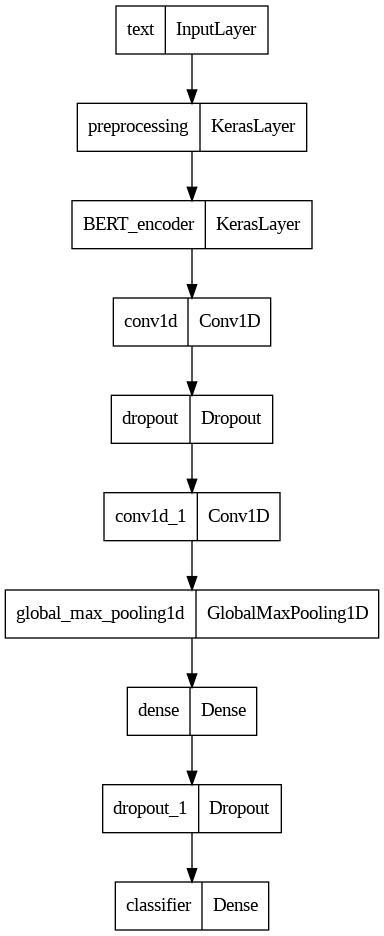

In [30]:
tf.keras.utils.plot_model(cnn_classifier_model)

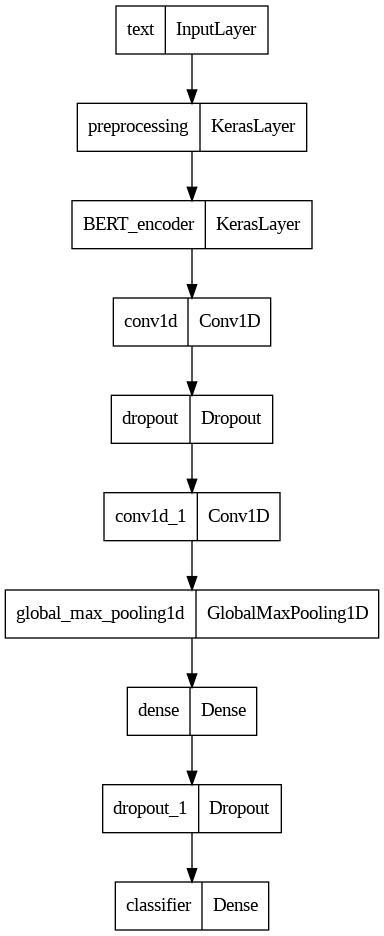

In [31]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [32]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
#metrics = tf.metrics.Accuracy()

In [33]:
for batch in train_ds.take(1):
    print(batch)


(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'&amp;when they say him they mean dyke Ron #wcw http://t.co/VV4DUMMe4A',
       b'@STACCS_WNT_FOLD you tell me, coon.',
       b'so turns out my history teacher who hated me has Corona and this is what she gets for sending me to the office when she asked what did Christopher Columbus do and I raised my hand and said he p?wherad Native Americans. LIKE DID I LIE',
       b"me: so it won't surprise you that he knows it's in your glove box now &amp; they want to take it after you sleep to shoot the gator?  mom: to dad: I told you not to bring that thing on vacation     to me: thank you  &amp; off they went to handle their immediate problem",
       b"@TwoStarScoob good job tonight! You need to haupa some crackers so,you'll stop throwing up !",
       b'Tmw your watching Yu-Gi-Oh as Kaiba patu Joey and at the same time my husband starts to aggressively hump me yelling "you\'re a third rate duelist with a fourth rate dick!"',
       b'@1

In [34]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [35]:
# Fit the model with proper dataset inputs
cnn_history = cnn_classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 66s 614ms/step - loss: 3.0841 - accuracy: 0.5393 - val_loss: 2.7377 - val_accuracy: 0.7821
Epoch 2/5
75/75 [==============================] - 45s 599ms/step - loss: 2.5993 - accuracy: 0.8207 - val_loss: 2.4666 - val_accuracy: 0.8841
Epoch 3/5
75/75 [==============================] - 45s 597ms/step - loss: 2.3949 - accuracy: 0.8992 - val_loss: 2.3547 - val_accuracy: 0.9169
Epoch 4/5
75/75 [==============================] - 45s 597ms/step - loss: 2.2537 - accuracy: 0.9496 - val_loss: 2.3119 - val_accuracy: 0.9332
Epoch 5/5
75/75 [==============================] - 45s 596ms/step - loss: 2.1971 - accuracy: 0.9685 - val_loss: 2.2843 - val_accuracy: 0.9345


In [36]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

83/83 [==============================] - 14s 166ms/step - loss: 2.3027 - accuracy: 0.9286
Loss: 2.302694797515869
Accuracy: 0.9285984039306641


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


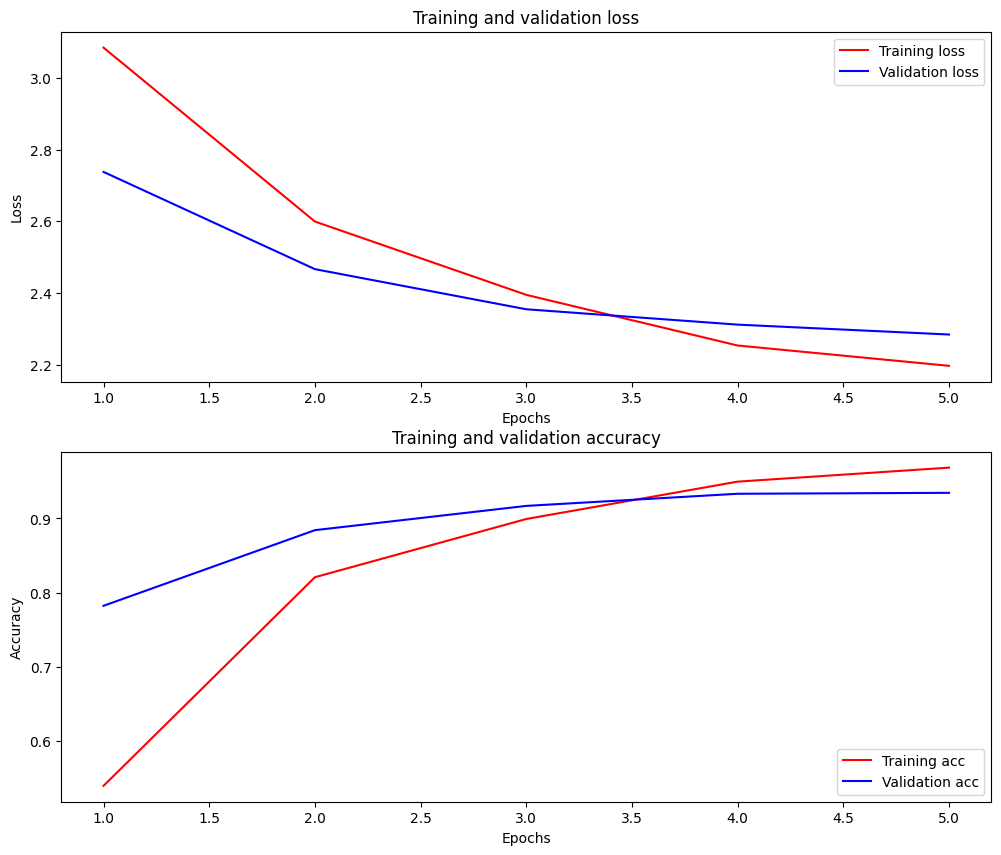

In [37]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
#"bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
#b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [38]:
dataset_name = '/content/Maoriwords_violencedataset.csv'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

cnn_classifier_model.save(saved_model_path, include_optimizer=False)

In [39]:
reloaded_model = tf.saved_model.load(saved_model_path)

Results for CNN

In [40]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

83/83 [==============================] - 15s 162ms/step
(2647, 3)


In [41]:
result[0:2]

array([[0.00612141, 0.9817695 , 0.01210904],
       [0.07934204, 0.04794642, 0.87271154]], dtype=float32)

In [42]:
for tweet, classes in test_ds:
    for i in classes:
       print(i)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype

In [43]:
classes = np.argmax(result, axis=-1)

Doing predictions and saving to np.array

In [44]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(tweet))

1/1 [==============================] - 1s 1s/step


In [45]:
test_labels[0:2]

[array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

In [46]:
predictions[0:2]

[array([[0.00612141, 0.9817695 , 0.01210904],
        [0.07934204, 0.04794642, 0.87271154],
        [0.17825985, 0.43719712, 0.38454297],
        [0.10033525, 0.07402731, 0.8256374 ],
        [0.09359831, 0.05985532, 0.8465464 ],
        [0.0161935 , 0.952867  , 0.03093958],
        [0.08755812, 0.6679799 , 0.24446197],
        [0.6970238 , 0.08923968, 0.2137365 ],
        [0.00833646, 0.9766788 , 0.01498476],
        [0.01987023, 0.94222295, 0.03790684],
        [0.1154846 , 0.07799035, 0.80652505],
        [0.09680425, 0.03917576, 0.86402005],
        [0.08810899, 0.05767184, 0.85421914],
        [0.09984165, 0.07251239, 0.82764596],
        [0.08827594, 0.04816882, 0.8635552 ],
        [0.10498535, 0.6096042 , 0.28541043],
        [0.02192969, 0.9418513 , 0.03621907],
        [0.07968938, 0.72906584, 0.19124489],
        [0.09945892, 0.6300155 , 0.27052557],
        [0.12626544, 0.51154035, 0.36219415],
        [0.1120497 , 0.06590305, 0.82204723],
        [0.8378957 , 0.06510379, 0

In [47]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [48]:
type(y_pred)

numpy.ndarray

In [49]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [50]:
type(y_test)

numpy.ndarray

Confusion Matrix CNN

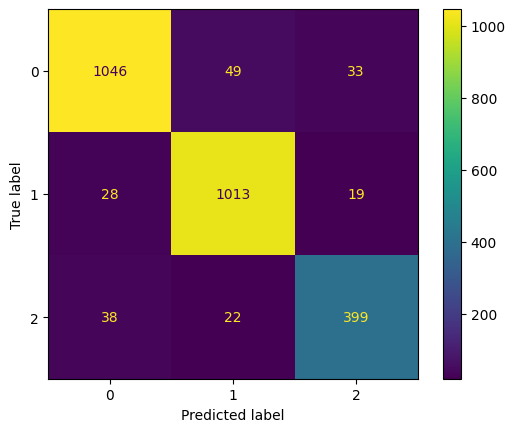

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1128
           1       0.93      0.96      0.94      1060
           2       0.88      0.87      0.88       459

    accuracy                           0.93      2647
   macro avg       0.92      0.92      0.92      2647
weighted avg       0.93      0.93      0.93      2647



In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

CNN_test=y_test
CNN_pred=y_pred

confusion_matrix = metrics.confusion_matrix(CNN_test, CNN_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2])

cm_display.plot()
plt.show()

from sklearn.metrics import classification_report
print(classification_report(CNN_test, CNN_pred))

MODIFICATIONS FOR HIGH ACCUARCU

In [52]:
from sklearn.metrics import classification_report

# Function to evaluate model on the test set
def evaluate_model(model, test_dataset):
    y_true = []
    y_pred = []

    for text, label in test_dataset:
        predictions = model.predict(text)
        y_true.extend(label.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    print(classification_report(y_true, y_pred, target_names=['sexual_violence', 'physical_violence', 'non_violence']))

# Call the evaluation function
evaluate_model(cnn_classifier_model, test_ds)

1/1 [==============================] - 0s 52ms/step
                   precision    recall  f1-score   support

  sexual_violence       0.94      0.93      0.93      1128
physical_violence       0.93      0.96      0.94      1060
     non_violence       0.88      0.87      0.88       459

         accuracy                           0.93      2647
        macro avg       0.92      0.92      0.92      2647
     weighted avg       0.93      0.93      0.93      2647



In [53]:
#2. Check Data Splits
# Ensure there is no overlap between train, validation, and test sets
train_indices = set(X_train)
val_indices = set(X_val)
test_indices = set(X_test)

assert train_indices.isdisjoint(val_indices), "Train and validation sets overlap!"
assert train_indices.isdisjoint(test_indices), "Train and test sets overlap!"
assert val_indices.isdisjoint(test_indices), "Validation and test sets overlap!"

In [54]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs["sequence_output"]  # Use sequence output for CNN

    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)  # Add dropout layer

    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)

    net = tf.keras.layers.Dense(768, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.3)(net)  # Add dropout layer

    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

cnn_classifier_model = build_CNN_classifier_model()


In [55]:
#Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [56]:
#Reduce Learning Rate
initial_learning_rate = 1e-6  # Reduced learning rate

cnn_classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

history = cnn_classifier_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]  # Use early stopping
)


Epoch 1/10
75/75 [==============================] - 83s 600ms/step - loss: 1.0860 - accuracy: 0.4087 - val_loss: 1.0392 - val_accuracy: 0.4288
Epoch 2/10
75/75 [==============================] - 43s 571ms/step - loss: 1.0487 - accuracy: 0.4418 - val_loss: 0.9830 - val_accuracy: 0.4377
Epoch 3/10
75/75 [==============================] - 43s 572ms/step - loss: 0.9938 - accuracy: 0.4943 - val_loss: 0.9184 - val_accuracy: 0.5157
Epoch 4/10
75/75 [==============================] - 43s 571ms/step - loss: 0.9452 - accuracy: 0.5380 - val_loss: 0.8428 - val_accuracy: 0.6581
Epoch 5/10
75/75 [==============================] - 43s 570ms/step - loss: 0.8742 - accuracy: 0.5981 - val_loss: 0.7794 - val_accuracy: 0.7065
Epoch 6/10
75/75 [==============================] - 43s 570ms/step - loss: 0.8237 - accuracy: 0.6346 - val_loss: 0.7291 - val_accuracy: 0.7091
Epoch 7/10
75/75 [==============================] - 43s 571ms/step - loss: 0.7678 - accuracy: 0.6741 - val_loss: 0.6870 - val_accuracy: 0.7116

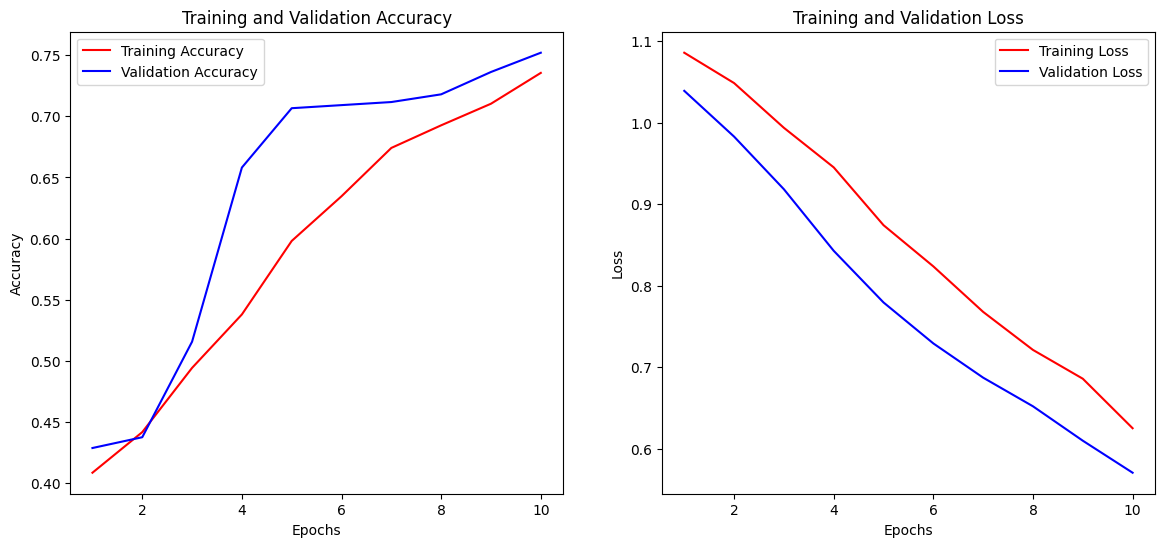

In [57]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the curves
plot_training_curves(history)


TEST DATA

1/1 [==============================] - 1s 1s/step
Classification Report:
                   precision    recall  f1-score   support

  sexual_violence       0.79      0.90      0.84      1128
physical_violence       0.71      0.92      0.80      1060
     non_violence       0.00      0.00      0.00       459

         accuracy                           0.75      2647
        macro avg       0.50      0.60      0.55      2647
     weighted avg       0.62      0.75      0.68      2647

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


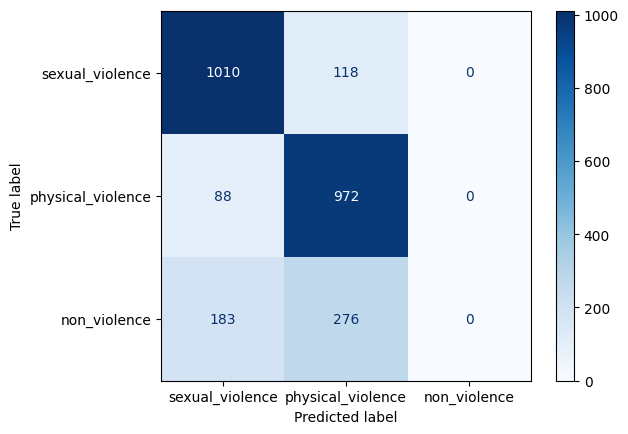

In [58]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to generate predictions and evaluate the model on the test set
def evaluate_model_on_test_data(model, test_dataset):
    y_true = []
    y_pred = []

    # Loop through the test dataset to get predictions and true labels
    for batch in test_dataset:
        text_batch, label_batch = batch
        predictions = model.predict(text_batch)
        y_true.extend(label_batch.numpy())  # Collect true labels
        y_pred.extend(np.argmax(predictions, axis=1))  # Collect predicted labels (class with highest probability)

    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['sexual_violence', 'physical_violence', 'non_violence']))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['sexual_violence', 'physical_violence', 'non_violence'])

    # Plot confusion matrix
    print("Confusion Matrix:")
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

# Call the function to evaluate the model on test data
evaluate_model_on_test_data(cnn_classifier_model, test_ds)

Class Weighting: NON VIOLENCE

In [59]:
# Calculate class weights based on the training dataset distribution
from sklearn.utils import class_weight
import numpy as np

# Assuming your labels are stored in y_train
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Pass class weights to the fit method
history = cnn_classifier_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, #changed epoch fom 10 to 20
    callbacks=[early_stopping],
    class_weight=class_weights_dict  # Pass the class weights
)


Epoch 1/20
75/75 [==============================] - 51s 582ms/step - loss: 0.7268 - accuracy: 0.7413 - val_loss: 0.5415 - val_accuracy: 0.7708
Epoch 2/20
75/75 [==============================] - 43s 571ms/step - loss: 0.6733 - accuracy: 0.7644 - val_loss: 0.5232 - val_accuracy: 0.8117
Epoch 3/20
75/75 [==============================] - 43s 575ms/step - loss: 0.6318 - accuracy: 0.7904 - val_loss: 0.4914 - val_accuracy: 0.8293
Epoch 4/20
75/75 [==============================] - 43s 571ms/step - loss: 0.5899 - accuracy: 0.8198 - val_loss: 0.4629 - val_accuracy: 0.8306
Epoch 5/20
75/75 [==============================] - 43s 574ms/step - loss: 0.5495 - accuracy: 0.8282 - val_loss: 0.4336 - val_accuracy: 0.8401
Epoch 6/20
75/75 [==============================] - 43s 575ms/step - loss: 0.5120 - accuracy: 0.8387 - val_loss: 0.4115 - val_accuracy: 0.8495
Epoch 7/20
75/75 [==============================] - 43s 574ms/step - loss: 0.4899 - accuracy: 0.8366 - val_loss: 0.3848 - val_accuracy: 0.8552

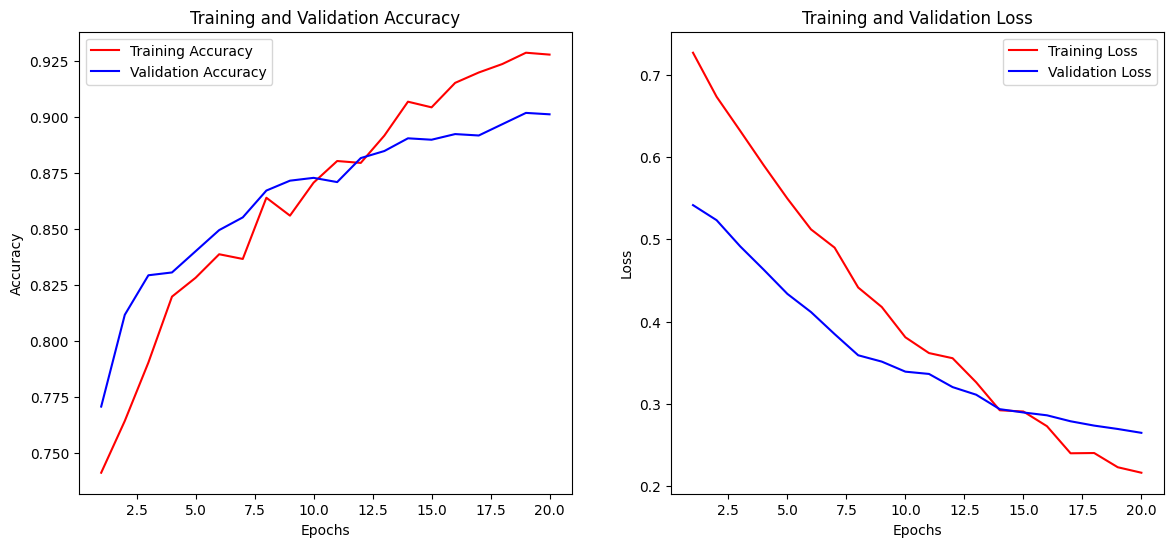

1/1 [==============================] - 0s 51ms/step
Classification Report:
                   precision    recall  f1-score   support

  sexual_violence       0.94      0.88      0.90      1128
physical_violence       0.94      0.93      0.93      1060
     non_violence       0.76      0.91      0.83       459

         accuracy                           0.90      2647
        macro avg       0.88      0.90      0.89      2647
     weighted avg       0.91      0.90      0.90      2647

Confusion Matrix:


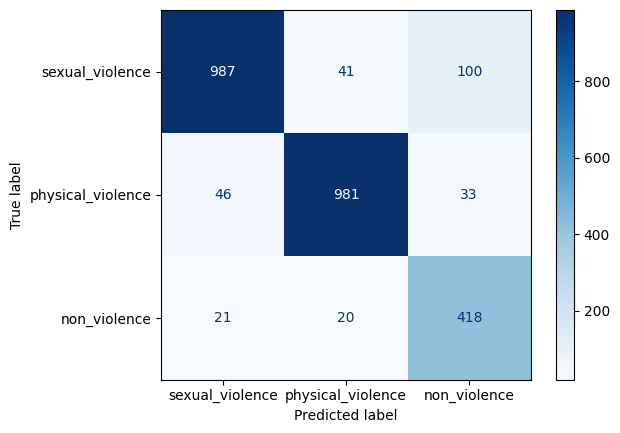

In [60]:
# Step 4: Plot the training and validation accuracy and loss after training
plot_training_curves(history)

# Step 5: Evaluate the model on the test dataset after training
evaluate_model_on_test_data(cnn_classifier_model, test_ds)

In [63]:
import re
import numpy as np
import pandas as pd

# Load your dataset (if not already loaded)
df = pd.read_csv('/content/Maoriwords_violencedataset.csv', encoding='ISO-8859-1')

# A list of known Māori words (this can be extended)
maori_words = ["pāwhera", "tūkino", "haupa", "mataku", "haka", "papaki", "patu", "whakapōraru", "Ātaahua", "rorohiko"]

# Function to identify Māori words in a text
def find_maori_words(text, maori_word_list):
    words_in_text = re.findall(r'\b\w+\b', text.lower())  # Extract all words from text
    return [word for word in words_in_text if word in maori_word_list]

# Function to evaluate model predictions and track misclassified examples with Māori words
def evaluate_model_and_find_misclassified_maori_words(model, test_data, maori_word_list):
    y_true = []
    y_pred = []
    misclassified_maori_words = {
        "sexual_violence": [],
        "physical_violence": [],
        "non_violence": []
    }

    # Class label names for reference
    class_names = ['sexual_violence', 'physical_violence', 'non_violence']

    for batch in test_data:
        text_batch, label_batch = batch
        predictions = model.predict(text_batch)
        y_true.extend(label_batch.numpy())  # Collect true labels
        predicted_classes = np.argmax(predictions, axis=1)  # Get predicted labels

        for tweet, true_label, pred_label in zip(text_batch, label_batch.numpy(), predicted_classes):
            if true_label != pred_label:
                # Check for Māori words in misclassified tweet
                tweet_text = tweet.numpy().decode('utf-8')  # Decode tweet from tensor to string
                maori_in_tweet = find_maori_words(tweet_text, maori_word_list)
                if maori_in_tweet:
                    # Append misclassified Māori words grouped by the true label
                    class_label = class_names[true_label]
                    misclassified_maori_words[class_label].append({
                        'tweet': tweet_text,
                        'predicted_class': class_names[pred_label],
                        'maori_word_count': len(maori_in_tweet),
                        'maori_words': maori_in_tweet
                    })

    return misclassified_maori_words

# Assuming 'test_ds' is the test dataset and 'cnn_classifier_model' is the trained model
misclassified_maori_words = evaluate_model_and_find_misclassified_maori_words(cnn_classifier_model, test_ds, maori_words)

# Function to print misclassified tweets in a readable format
def print_misclassified_maori_words(misclassified_tweets):
    for true_class, tweets in misclassified_tweets.items():
        print(f"True Class: {true_class}")
        if tweets:
            for idx, tweet_info in enumerate(tweets, 1):
                print(f"  {idx}. Tweet: {tweet_info['tweet']}")
                print(f"     Predicted Class: {tweet_info['predicted_class']}")
                print(f"     Māori Words Count: {tweet_info['maori_word_count']}")
                print(f"     Māori Words: {', '.join(tweet_info['maori_words'])}")
        else:
            print("  No misclassified tweets with Māori words.")
        print("\n")

# This function call would print the list of misclassified tweets with Māori words:
print_misclassified_maori_words(misclassified_maori_words)


1/1 [==============================] - 0s 51ms/step
True Class: sexual_violence
  1. Tweet: &#128514; RT @TheOnlyReed: LMFAO RT @Tone314: If you watching porn &amp; patu off &amp; yo homie text u &amp; it show his name in the banner you're a faggot
     Predicted Class: physical_violence
     Māori Words Count: 1
     Māori Words: patu
  2. Tweet: @Shvkxir @RickiRoma @BaeSongz @JayZOverrated Ahmed and retard mikey for special Olympic patu
     Predicted Class: non_violence
     Māori Words Count: 1
     Māori Words: patu
  3. Tweet: @bad_boy_six @ksteven37 
Here ya go wetback, haupa this.. http://t.co/kf6PgZvH5G
     Predicted Class: non_violence
     Māori Words Count: 1
     Māori Words: haupa
  4. Tweet: And I'm definitely top 3 at makin patu in the city but y'all niggers love your trap patu so y'all probably won't admit that
     Predicted Class: physical_violence
     Māori Words Count: 2
     Māori Words: patu, patu


True Class: physical_violence
  1. Tweet: My Husband p?wherad 

In [67]:
# Function to evaluate model predictions and track all misclassified examples (with or without Māori words)
def evaluate_model_and_find_all_misclassified_sentences(model, test_data, maori_word_list):
    y_true = []
    y_pred = []
    misclassified_tweets = {
        "sexual_violence": [],
        "physical_violence": [],
        "non_violence": []
    }

    # Class label names for reference
    class_names = ['sexual_violence', 'physical_violence', 'non_violence']

    for batch in test_data:
        text_batch, label_batch = batch
        predictions = model.predict(text_batch)
        y_true.extend(label_batch.numpy())  # Collect true labels
        predicted_classes = np.argmax(predictions, axis=1)  # Get predicted labels

        for tweet, true_label, pred_label in zip(text_batch, label_batch.numpy(), predicted_classes):
            if true_label != pred_label:
                # Check for Māori words in misclassified tweet
                tweet_text = tweet.numpy().decode('utf-8')  # Decode tweet from tensor to string
                maori_in_tweet = find_maori_words(tweet_text, maori_word_list)
                # Append all misclassified tweets, whether or not they contain Māori words
                class_label = class_names[true_label]
                misclassified_tweets[class_label].append({
                    'tweet': tweet_text,
                    'predicted_class': class_names[pred_label],
                    'maori_word_count': len(maori_in_tweet),
                    'maori_words': maori_in_tweet
                })

    return misclassified_tweets
# Function to print all misclassified tweets, including those without Māori words
misclassified_tweets = evaluate_model_and_find_all_misclassified_sentences(cnn_classifier_model, test_ds, maori_words)
def print_all_misclassified_tweets(misclassified_tweets):
    for true_class, tweets in misclassified_tweets.items():
        print(f"True Class: {true_class}")
        if tweets:
            for idx, tweet_info in enumerate(tweets, 1):
                print(f"  {idx}. Tweet: {tweet_info['tweet']}")
                print(f"     Predicted Class: {tweet_info['predicted_class']}")
                print(f"     Māori Words Count: {tweet_info['maori_word_count']}")
                if tweet_info['maori_word_count'] > 0:
                    print(f"     Māori Words: {', '.join(tweet_info['maori_words'])}")
        else:
            print("  No misclassified tweets.")
        print("\n")

# This function call would print the list of all misclassified tweets (whether or not they contain Māori words):
print_all_misclassified_tweets(misclassified_tweets)

1/1 [==============================] - 0s 50ms/step
True Class: sexual_violence
  1. Tweet: #NAME?
     Predicted Class: physical_violence
     Māori Words Count: 0
  2. Tweet:  DO SOMETHING! princess leia is being forced to listen to me and the prom queen have nasty perverted drunk sexâ
     Predicted Class: physical_violence
     Māori Words Count: 0
  3. Tweet: MY STORY: How I Was Brutally Defiled By A Friend While Trying To Get A Job (PLUS...    
     Predicted Class: non_violence
     Māori Words Count: 0
  4. Tweet: The confidence though !!!!!  He was like "Yes b!tches, that was me, I got spanked once on my buttocks" ðððð»
     Predicted Class: physical_violence
     Māori Words Count: 0
  5. Tweet: MY STORY: âMy Father defiled Me, And My Mother Blamed Meâ: I was defiled from age of 12 to 16 and ...  
     Predicted Class: physical_violence
     Māori Words Count: 0
  6. Tweet: LANTERNAPOST: was inebriated after I defiled my daughter but she turned into not a fat

In [68]:
# Function to print only the misclassified tweets in the "non_violence" class
def print_misclassified_non_violence_tweets(misclassified_tweets):
    non_violence_misclassified = misclassified_tweets.get("non_violence", [])

    if non_violence_misclassified:
        print("Misclassified 'Non-Violence' Tweets:")
        for idx, tweet_info in enumerate(non_violence_misclassified, 1):
            print(f"  {idx}. Tweet: {tweet_info['tweet']}")
            print(f"     Predicted Class: {tweet_info['predicted_class']}")
            print(f"     Māori Words Count: {tweet_info['maori_word_count']}")
            if tweet_info['maori_word_count'] > 0:
                print(f"     Māori Words: {', '.join(tweet_info['maori_words'])}")
    else:
        print("  No misclassified tweets in 'Non-Violence' class.")

# Call this function with the output of the evaluation function
print_misclassified_non_violence_tweets(misclassified_tweets)


Misclassified 'Non-Violence' Tweets:
  1. Tweet: "@FunnyPicsDepot: this the "I play soccer, chhaupa on girls, and wear khaki coloured cargos" haircut http://t.co/ZUai7qWBIR" &#128514; yup
     Predicted Class: physical_violence
     Māori Words Count: 0
  2. Tweet: "@MaxMayo77: http://t.co/PrrskknqRv" love frat boy w/ soft long soles
     Predicted Class: physical_violence
     Māori Words Count: 0
  3. Tweet: "@QUAN1T0: 61% of welfare/government aid is claimed by white people. So y'all black slander is trash now."
     Predicted Class: sexual_violence
     Māori Words Count: 0
  4. Tweet: "@RamBoutIt: &#8220;@Master11_: @20ToLife_ @RamBoutIt hoes Austin&#8221; teach us Austin."I teach u how to get curved? That's all I know
     Predicted Class: physical_violence
     Māori Words Count: 0
  5. Tweet: "@TEE_JONEZ: @16stanleys @KingCuh tuku ho idk blah blah blah" &#128514;&#128514;&#128514;
     Predicted Class: physical_violence
     Māori Words Count: 0
  6. Tweet: "@iTrapWatermelon: t